In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import shap
import lime
import os
import joblib
from IPython.display import IFrame
import tempfile
import warnings
import statsmodels.api as sm

warnings.filterwarnings('ignore')
# import dask.dataframe as dd


In [2]:
exps_dir = "../../exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/exp"
os.makedirs(save_dir, exist_ok=True)

In [3]:
style_dir='../../styles'
plt.style.use(f'{style_dir}/style.mplstyle')
shap.initjs()

In [4]:
ndays=1
X=pd.read_csv(f'{save_dir}/X_train_lag{ndays}_pre_processing.csv', index_col=None)
y=pd.read_csv(f'{save_dir}/y_train_lag{ndays}_pre_processing.csv', index_col=None)
X_train=pd.read_csv(f'{save_dir}/X_train_train_lag{ndays}_pre_processing.csv', index_col=None)
X_valid=pd.read_csv(f'{save_dir}/X_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
y_train=pd.read_csv(f'{save_dir}/y_train_train_lag{ndays}_pre_processing.csv', index_col=None)
y_valid=pd.read_csv(f'{save_dir}/y_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
best_params = dict(np.load(f'{save_dir}/best_params_.npz',allow_pickle=True))
scaler_y=joblib.load(f'{save_dir}/scaler_y.pkl')
# target=pd.read_csv(f'{save_dir}/Y{ndays}_pre_processing.csv', index_col=None)
target_valid=pd.read_csv(f'{save_dir}/target_valid{ndays}_pre_processing.csv', index_col=None)
# target.drop(columns=['Unnamed: 0'], inplace=True)
target_valid.drop(columns=['Unnamed: 0'], inplace=True)
# print(target.shape,target_valid.shape)

In [5]:
X.drop(columns=['Unnamed: 0'], inplace=True)
y.drop(columns=['Unnamed: 0'], inplace=True)
X_train.drop(columns=['Unnamed: 0'], inplace=True)
X_valid.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
y_valid.drop(columns=['Unnamed: 0'], inplace=True)
print(X.shape, y.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(67714, 93) (67714, 1) (45368, 93) (45368, 1) (22346, 93) (22346, 1)


### Analyze the regression relation

#### Use OLS regression

In [6]:
def analyze_OLS(x,y):
    x = sm.add_constant(x)  
    model = sm.OLS(y, x,hasconst=True)
    results = model.fit()
    summary = results.summary()
    # print(summary)
    return summary
print(analyze_OLS(X,y))

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     839.3
Date:                Tue, 09 Jul 2024   Prob (F-statistic):               0.00
Time:                        12:28:51   Log-Likelihood:            -7.4505e+05
No. Observations:               67714   AIC:                         1.490e+06
Df Residuals:                   67621   BIC:                         1.491e+06
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

#### Use Linear machine learning model

In [7]:
def print_sorted_coefficients(model, model_name, feature_names):
    coef = model.coef_
    if len(coef.shape) > 1:
        coef = coef[0]
    sorted_indices = np.argsort(-np.abs(coef))  
    sorted_coef = coef[sorted_indices]
    sorted_feature_names = [feature_names[i] for i in sorted_indices]
    for i, (name, value) in enumerate(zip(sorted_feature_names, sorted_coef)):
        print(f"{model_name} Coefficient {i + 1}: {name}, Coefficient: {value}")

In [8]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_valid)

print_sorted_coefficients(linear_model, "Linear Regression", X_train.columns)
print("Linear Regression intercept:", linear_model.intercept_)





Linear Regression Coefficient 1: shortwave_radiation_hl_7d, Coefficient: 114649.11754525655
Linear Regression Coefficient 2: direct_solar_radiation_hl_7d, Coefficient: -87992.9015631223
Linear Regression Coefficient 3: shortwave_radiation, Coefficient: -57003.960103050165
Linear Regression Coefficient 4: direct_solar_radiation_hd_7d, Coefficient: 42975.756690409085
Linear Regression Coefficient 5: diffuse_radiation_hl_7d, Coefficient: -36751.201793012784
Linear Regression Coefficient 6: diffuse_radiation, Coefficient: 17637.654768375887
Linear Regression Coefficient 7: installed_capacity, Coefficient: 0.9476469338782759
Linear Regression Coefficient 8: eic_count, Coefficient: -0.4272853657682134
Linear Regression Coefficient 9: is_consumption, Coefficient: 0.3991867624713435
Linear Regression Coefficient 10: temperature_hl_7d, Coefficient: 0.09711602347214622
Linear Regression Coefficient 11: temperature, Coefficient: 0.07720222690617978
Linear Regression Coefficient 12: temperature_hd

In [9]:
print("Linear Regression R²:", r2_score(y_valid, y_pred_linear))
print("Linear Regression MAE:", mean_absolute_error(y_valid, y_pred_linear))

Linear Regression R²: -2025315.3580503324
Linear Regression MAE: 971.346021669655


In [10]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_valid)



print_sorted_coefficients(ridge_model, "Ridge Regression", X_train.columns)
print("Ridge Regression intercept:", ridge_model.intercept_)







Ridge Regression Coefficient 1: installed_capacity, Coefficient: 0.9475516116705219
Ridge Regression Coefficient 2: eic_count, Coefficient: -0.4272086671063714
Ridge Regression Coefficient 3: is_consumption, Coefficient: 0.39915167459956347
Ridge Regression Coefficient 4: temperature_hl_7d, Coefficient: 0.09386503209899473
Ridge Regression Coefficient 5: temperature, Coefficient: 0.07190609133744735
Ridge Regression Coefficient 6: temperature_fl_7d, Coefficient: -0.06784422768881083
Ridge Regression Coefficient 7: cos(dayofyear), Coefficient: 0.06726236784176991
Ridge Regression Coefficient 8: temperature_hd_7d, Coefficient: -0.06338663351622707
Ridge Regression Coefficient 9: temperature_fd_7d, Coefficient: 0.053983791481426464
Ridge Regression Coefficient 10: dewpoint_hl_7d, Coefficient: -0.05212334364717776
Ridge Regression Coefficient 11: temperature_fl, Coefficient: -0.042914153379899234
Ridge Regression Coefficient 12: direct_solar_radiation, Coefficient: 0.04070116229007359
Ridg

In [11]:
print("Ridge Regression R²:", r2_score(y_valid, y_pred_ridge))
print("Ridge Regression MAE:", mean_absolute_error(y_valid, y_pred_ridge))

Ridge Regression R²: 0.5363266400674789
Ridge Regression MAE: 0.30717713895152654


### Build Decision Tree and Improve in valid set

In [12]:
# dt_model = DecisionTreeRegressor(random_state=42, **best_params['dt_grid_search'].item())
# dt_model.fit(X_train, y_train)
# dump(dt_model, f'{save_dir}/dt_model_tuning.joblib')
dt_model=joblib.load(f'{save_dir}/dt_model_tuning.joblib')



In [13]:
dt_valid_predictions = dt_model.predict(X_valid)
y_pred = scaler_y.inverse_transform(dt_valid_predictions.reshape(-1, 1))
dt_valid_mae = mean_absolute_error(target_valid, y_pred)
dt_valid_r2 = r2_score(target_valid, y_pred)
print(f"Decision Tree - Validation MAE: {dt_valid_mae:.3f}, Validation R2: {dt_valid_r2:.3f}")


Decision Tree - Validation MAE: 2928.204, Validation R2: 0.899


In [14]:
importances = dt_model.feature_importances_
indices = np.argsort(importances)[::-1]

In [15]:
print("Feature ranking:")
for i, index in enumerate(indices):
    print(f"{i + 1}. feature {X.columns[index]} ({importances[index]})")

Feature ranking:
1. feature installed_capacity (0.4783252342587192)
2. feature segment (0.3975604384520356)
3. feature surface_solar_radiation_downwards_fl (0.03047588620481666)
4. feature is_consumption (0.024168667107034008)
5. feature is_business (0.01743510966177376)
6. feature data_block_id_right (0.0042799393434433414)
7. feature eic_count (0.004101822252675868)
8. feature surface_solar_radiation_downwards (0.0034903496059837244)
9. feature prediction_unit_id (0.00330644200514473)
10. feature cos(dayofyear) (0.0028702459361694818)
11. feature direct_solar_radiation_hd_7d (0.002629983886413334)
12. feature direct_solar_radiation (0.0018557609186789323)
13. feature county (0.0018424228553695439)
14. feature direct_solar_radiation_fl (0.0012459215415098802)
15. feature cloudcover_high_fl_7d (0.0009981503484854338)
16. feature cloudcover_high_fd_7d (0.0009086612295749369)
17. feature winddirection_10m (0.0008943956609027266)
18. feature euros_per_mwh (0.0008661267079237634)
19. featu

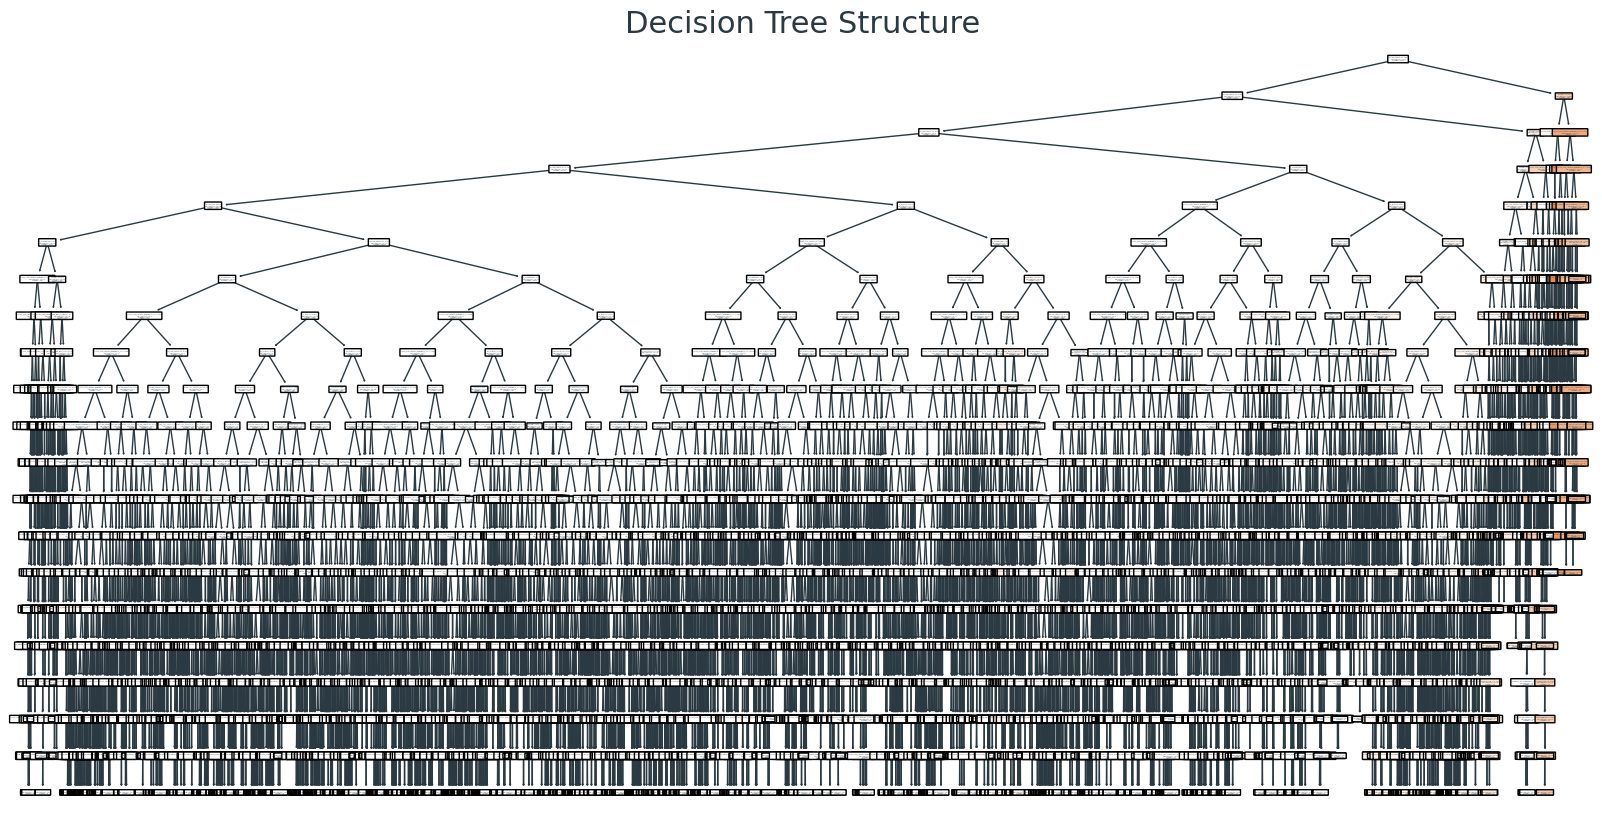

In [16]:
plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names=X_train.columns, filled=True, rounded=True)
plt.title("Decision Tree Structure")
plt.show()

### Use LIME, SHAP to explained

 96%|=================== | 21427/22346 [00:12<00:00]       

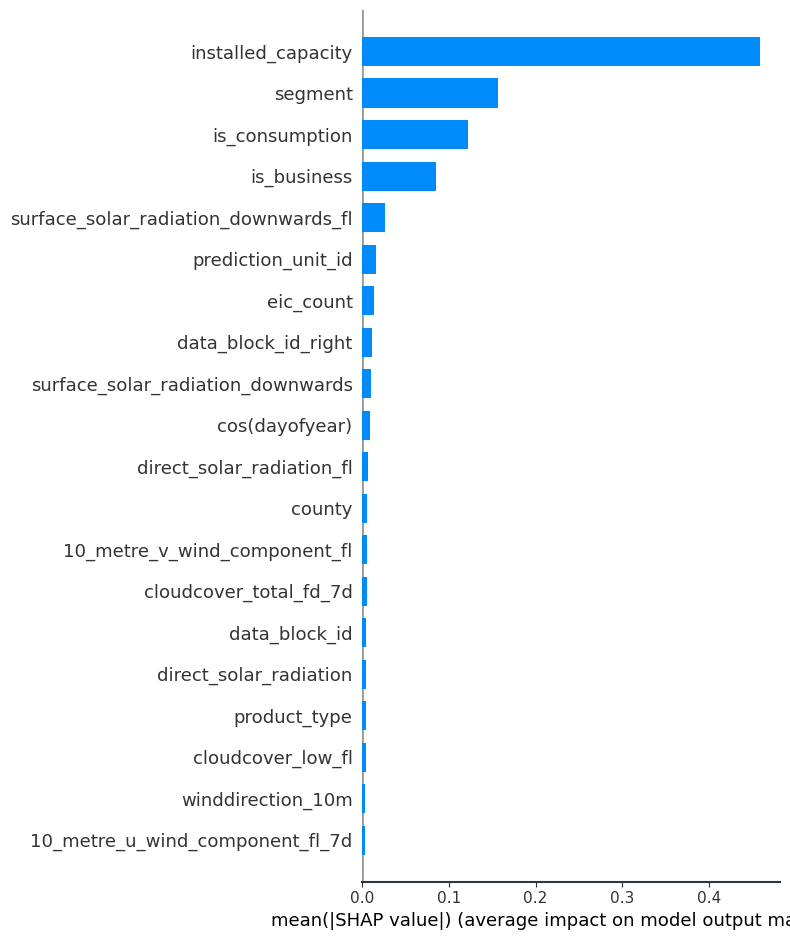

In [17]:
explainer_dt = shap.Explainer(dt_model, X_train)
shap_values_dt = explainer_dt(X_valid, check_additivity=False)


shap.summary_plot(shap_values_dt, X_valid, plot_type="bar", title="SHAP Decision Tree Feature Importance")


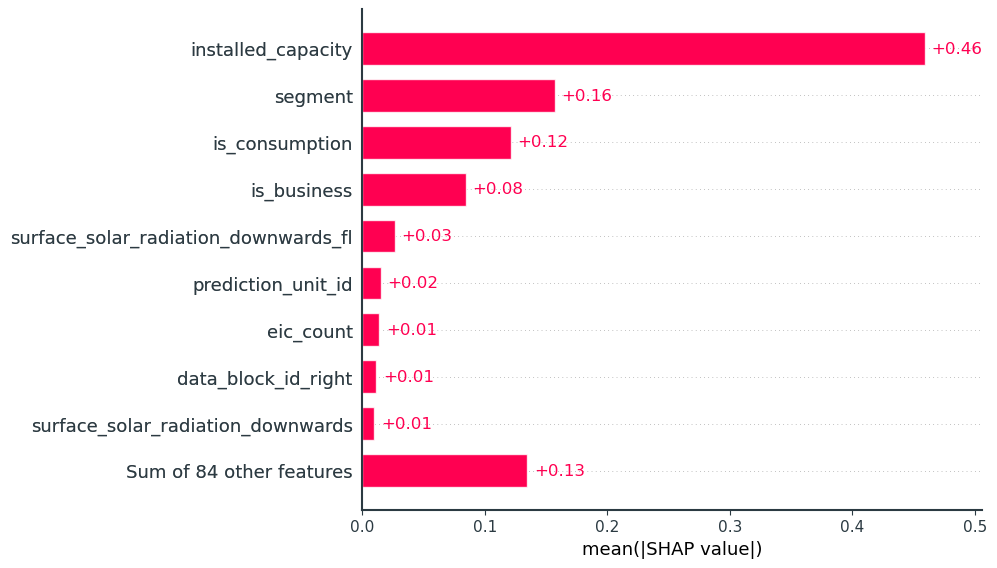

In [18]:
shap.plots.bar(shap_values_dt, show=False)
plt.show()
# plt.savefig("plots/bar.png")

In [19]:
i_med = np.argsort(dt_valid_predictions)[len(dt_valid_predictions)//2]
i_max = np.argmax(dt_valid_predictions)
i_80 = np.argsort(dt_valid_predictions)[int(len(dt_valid_predictions)*0.8)]
i_60 = np.argsort(dt_valid_predictions)[int(len(dt_valid_predictions)*0.6)]
i_40 = np.argsort(dt_valid_predictions)[int(len(dt_valid_predictions)*0.4)]
i_20 = np.argsort(dt_valid_predictions)[int(len(dt_valid_predictions)*0.2)]
i_min = np.argmin(dt_valid_predictions)

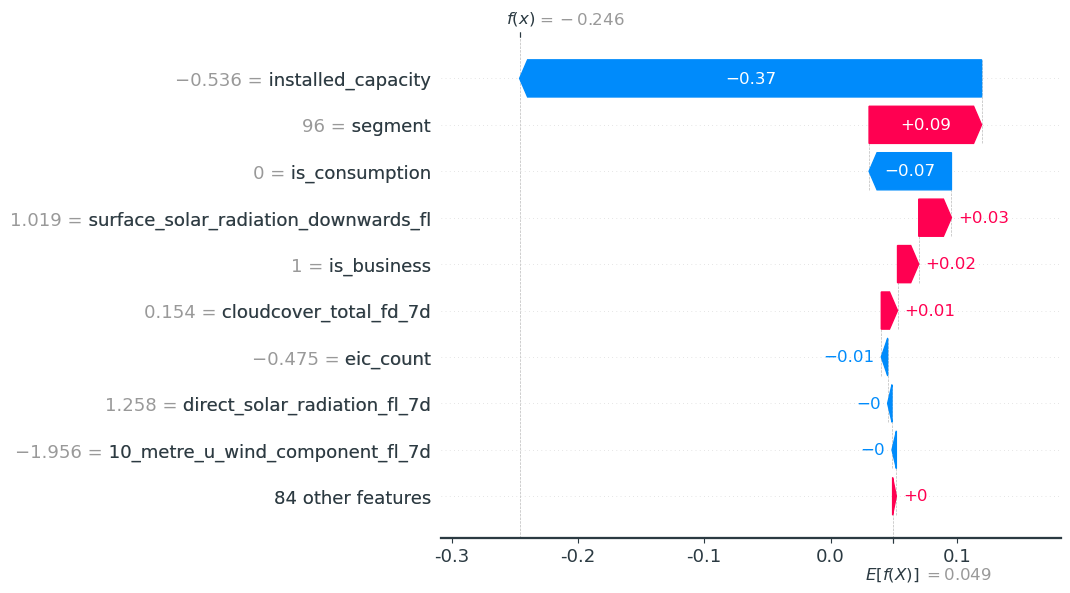

In [20]:
shap.plots.waterfall(shap_values_dt[i_med],show=True)
plt.show()
# plt.savefig("plots/waterfall_median.png")

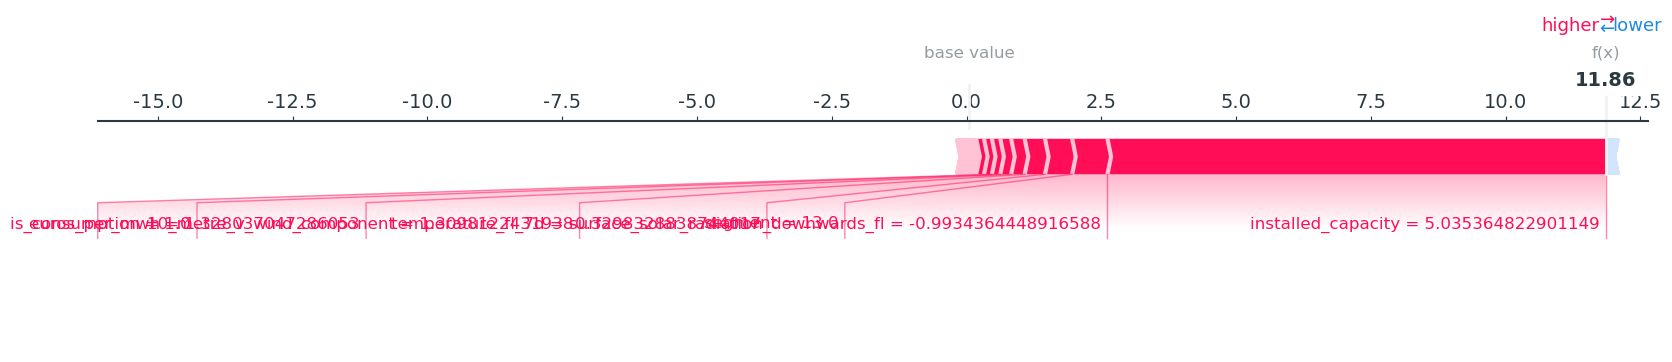

In [21]:
shap.plots.force(shap_values_dt[i_max], show=False, matplotlib=True)
plt.show()
# plt.savefig("plots/force_max.png")

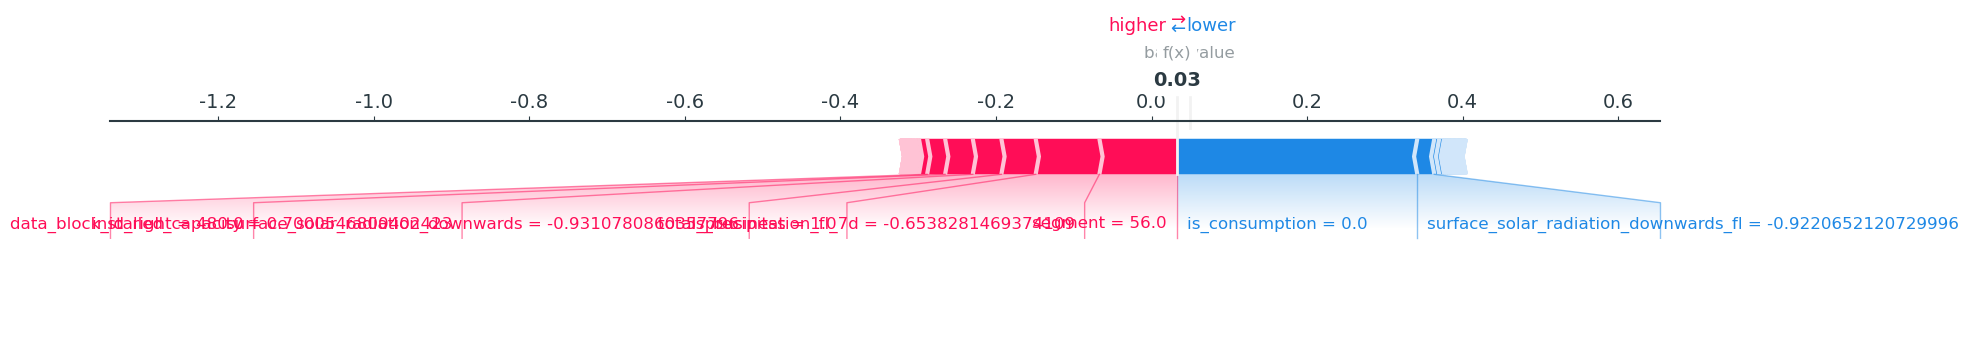

In [22]:
shap.plots.force(shap_values_dt[i_80], show=False, matplotlib=True)
plt.show()
# plt.savefig("plots/force_80.png")

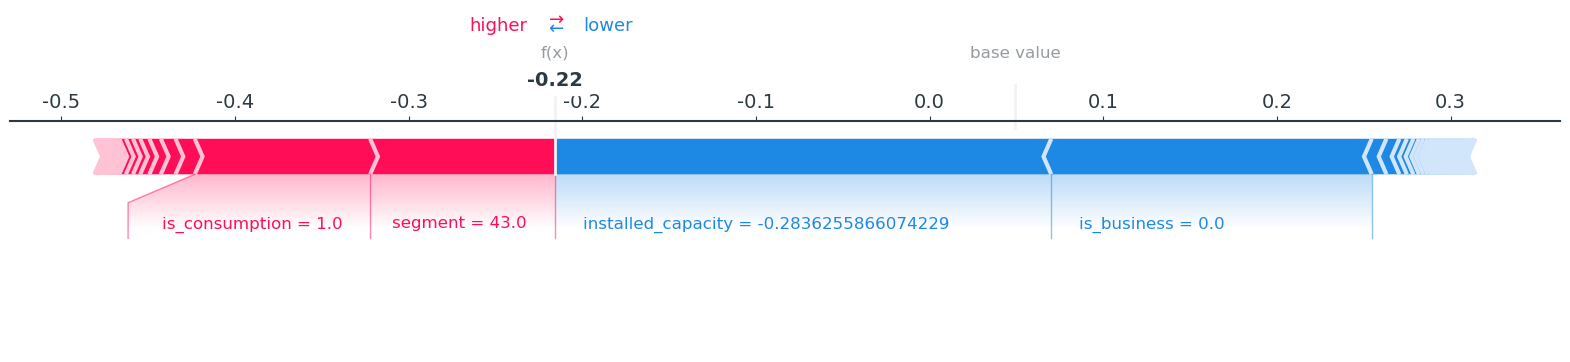

In [23]:
shap.plots.force(shap_values_dt[i_60], show=False, matplotlib=True)
plt.show()
# plt.savefig("plots/force_60.png")

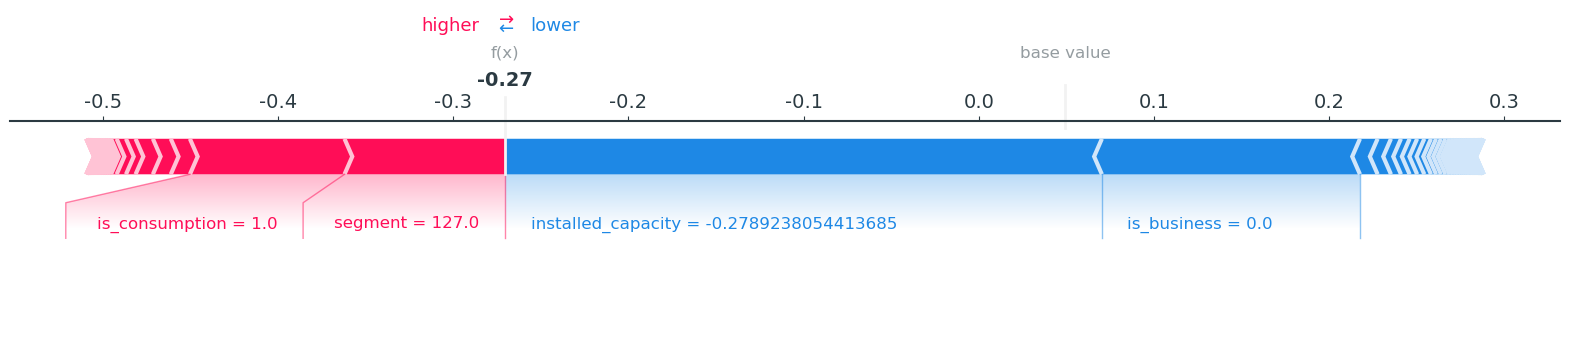

In [24]:
shap.plots.force(shap_values_dt[i_40], show=False, matplotlib=True)
plt.show()
# plt.savefig("plots/force_40.png")

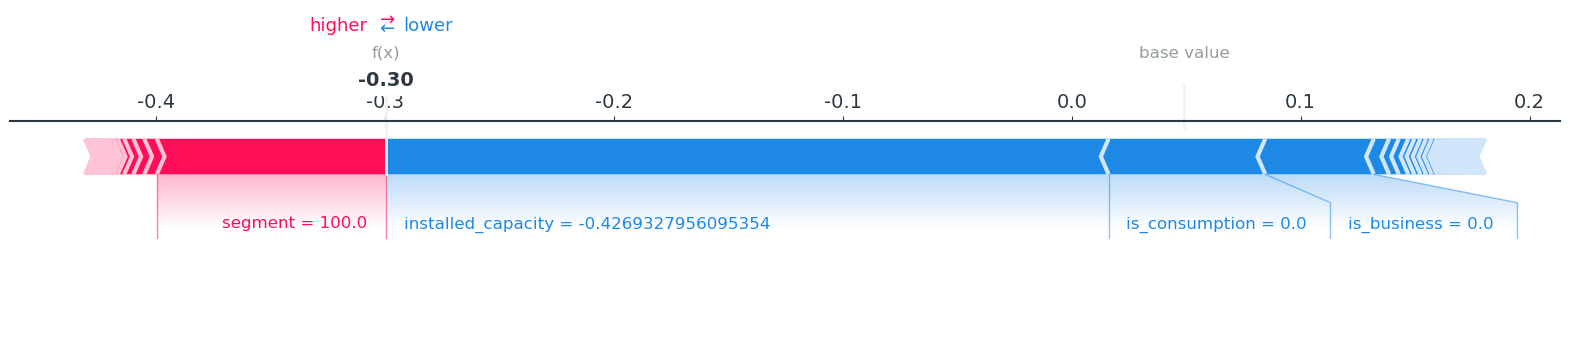

In [25]:
shap.plots.force(shap_values_dt[i_20], show=False, matplotlib=True)
plt.show()
# plt.savefig("plots/force_20.png")

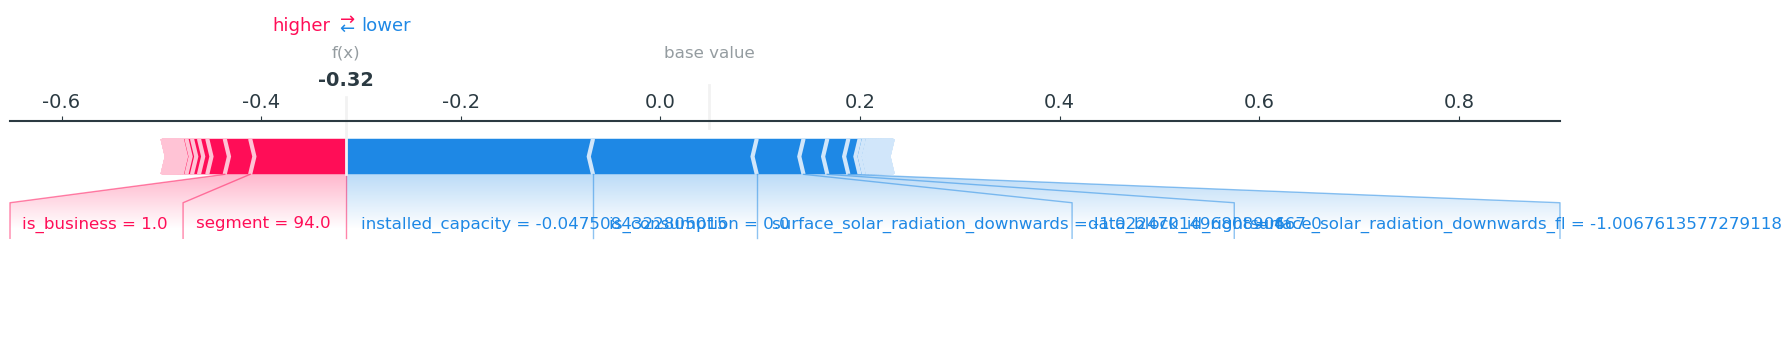

In [26]:
shap.plots.force(shap_values_dt[i_min], show=False, matplotlib=True)
plt.show()
# plt.savefig("plots/force_min.png")

In [27]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode="regression", feature_names=X_train.columns)
lime_exp_dt = explainer.explain_instance(X_valid.iloc[0].values, dt_model.predict)
file_name = f"{save_dir}/lime_explanation_dt.html"

lime_exp_dt.save_to_file(file_name)
lime_exp_dt.show_in_notebook()


### Build LGBM and Improve in valid set

In [28]:
# lgbm_model = lgb.LGBMRegressor(objective='regression',**best_params['lgb_grid_search'].item())
# lgbm_model.fit(X_train, y_train)
# dump(lgbm_model, f'{save_dir}/lgbm_model_tuning.joblib')
lgbm_model=joblib.load(f'{save_dir}/lgbm_model_tuning.joblib')



In [29]:
lgbm_model_predictions = lgbm_model.predict(X_valid)
y_pred = scaler_y.inverse_transform(lgbm_model_predictions.reshape(-1, 1))
lgbm_model_mae = mean_absolute_error(target_valid, y_pred)
lgbm_model_r2 = r2_score(target_valid, y_pred)
print(f"LGBM model - Validation MAE: {lgbm_model_mae:.3f}, Validation R2: {lgbm_model_r2:.3f}")

LGBM model - Validation MAE: 2478.570, Validation R2: 0.923


### Use LIME, SHAP to explained

100%|===================| 22339/22346 [01:46<00:00]        

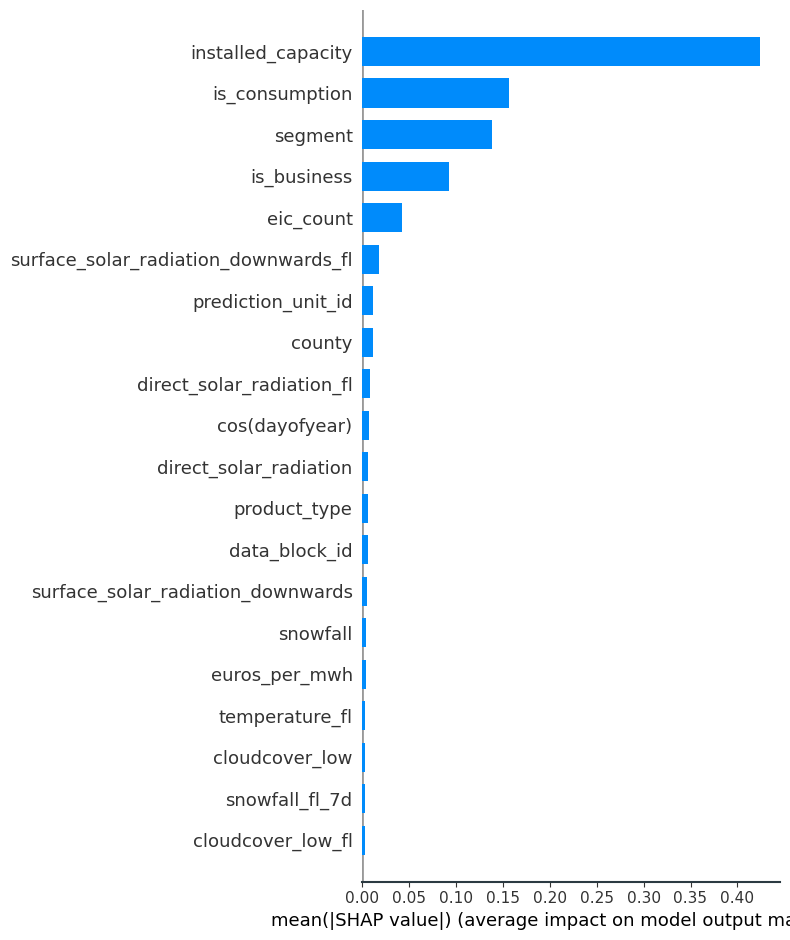

In [30]:
explainer_lgbm = shap.Explainer(lgbm_model, X_train)
shap_values_lgbm = explainer_lgbm(X_valid, check_additivity=False)


shap.summary_plot(shap_values_lgbm, X_valid, plot_type="bar", title="SHAP LGBM Feature Importance")



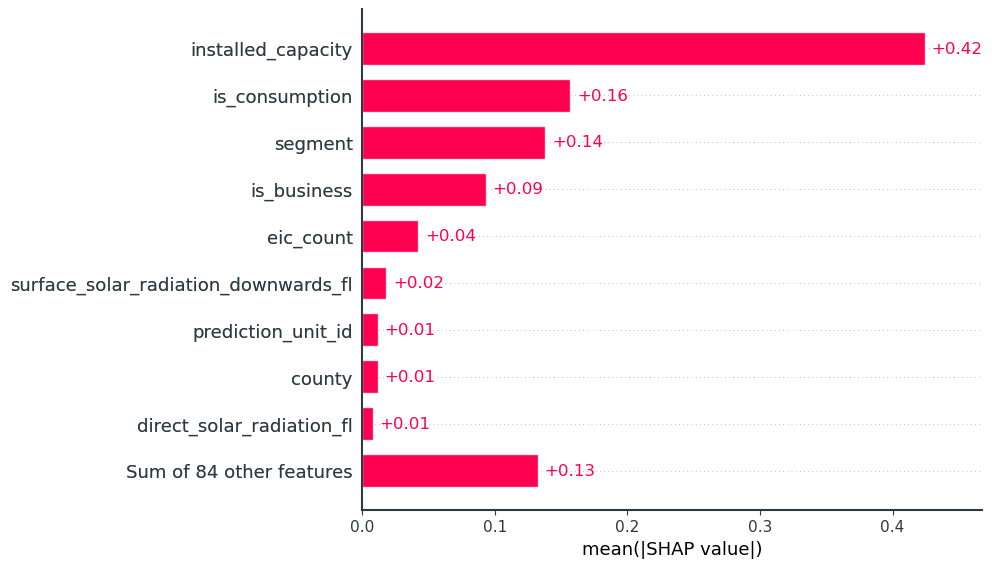

In [31]:
shap.plots.bar(shap_values_lgbm, show=False)
plt.show()
# plt.savefig("plots/bar.png")

In [32]:
i_med = np.argsort(lgbm_model_predictions)[len(lgbm_model_predictions)//2]
i_max = np.argmax(lgbm_model_predictions)
i_80 = np.argsort(lgbm_model_predictions)[int(len(lgbm_model_predictions)*0.8)]
i_60 = np.argsort(lgbm_model_predictions)[int(len(lgbm_model_predictions)*0.6)]
i_40 = np.argsort(lgbm_model_predictions)[int(len(lgbm_model_predictions)*0.4)]
i_20 = np.argsort(lgbm_model_predictions)[int(len(lgbm_model_predictions)*0.2)]
i_min = np.argmin(lgbm_model_predictions)

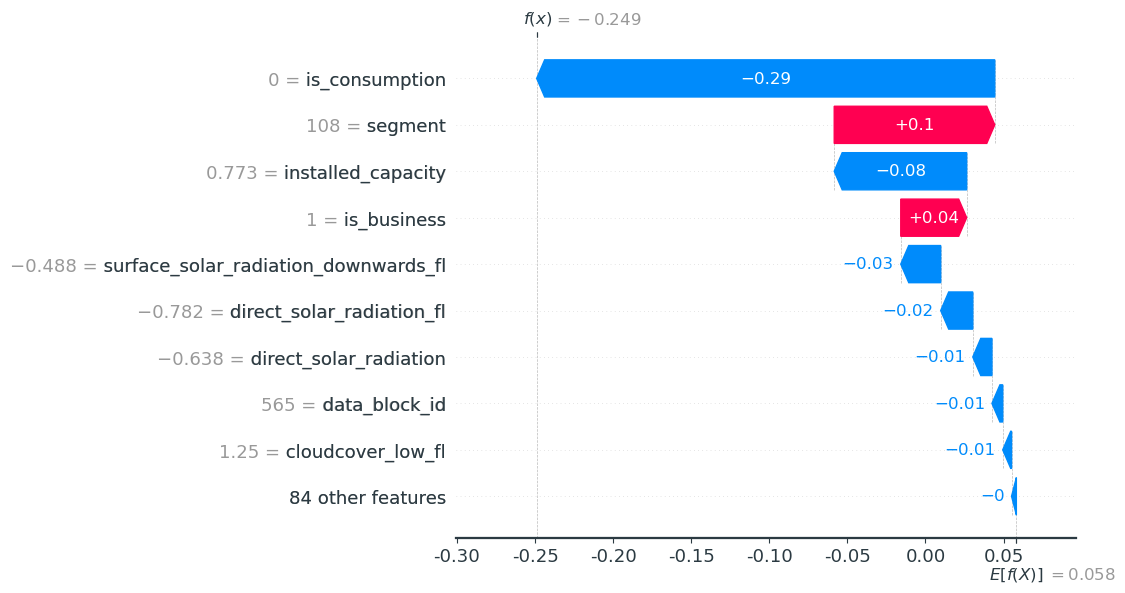

In [33]:
shap.plots.waterfall(shap_values_lgbm[i_med],show=True)
plt.show()

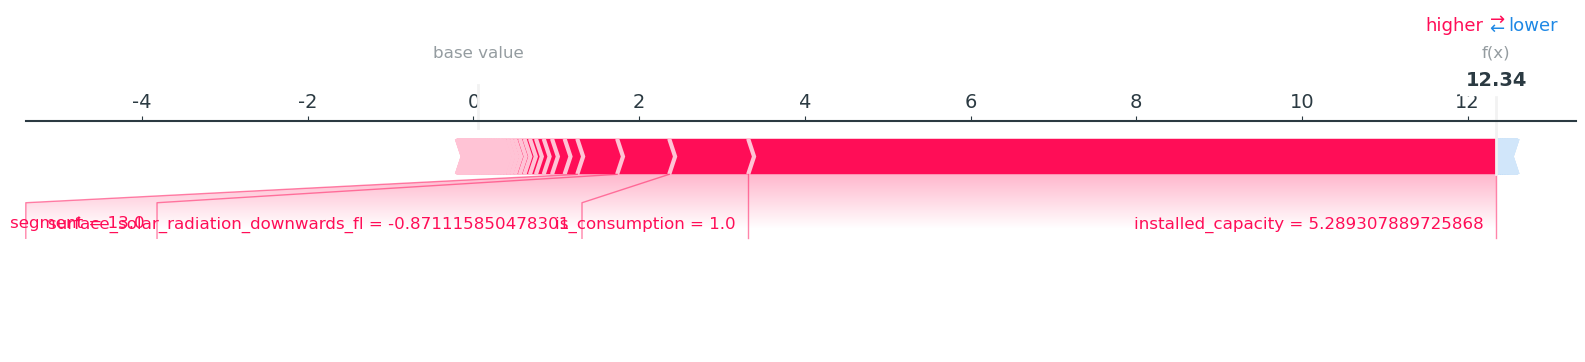

In [34]:
shap.plots.force(shap_values_lgbm[i_max], show=False, matplotlib=True)
plt.show()

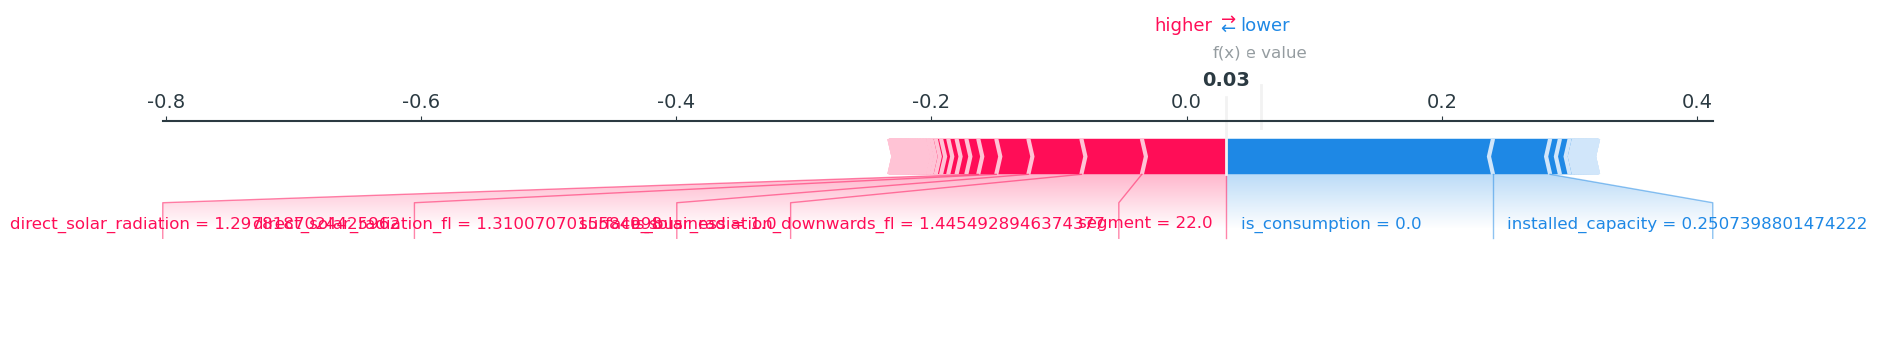

In [35]:
shap.plots.force(shap_values_lgbm[i_80], show=False, matplotlib=True)
plt.show()

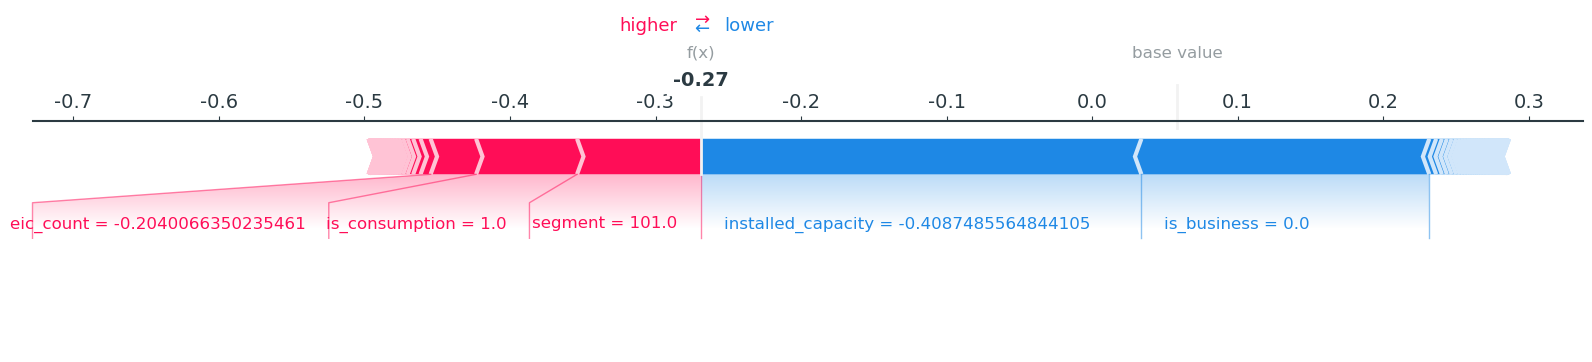

In [36]:
shap.plots.force(shap_values_lgbm[i_40], show=False, matplotlib=True)
plt.show()

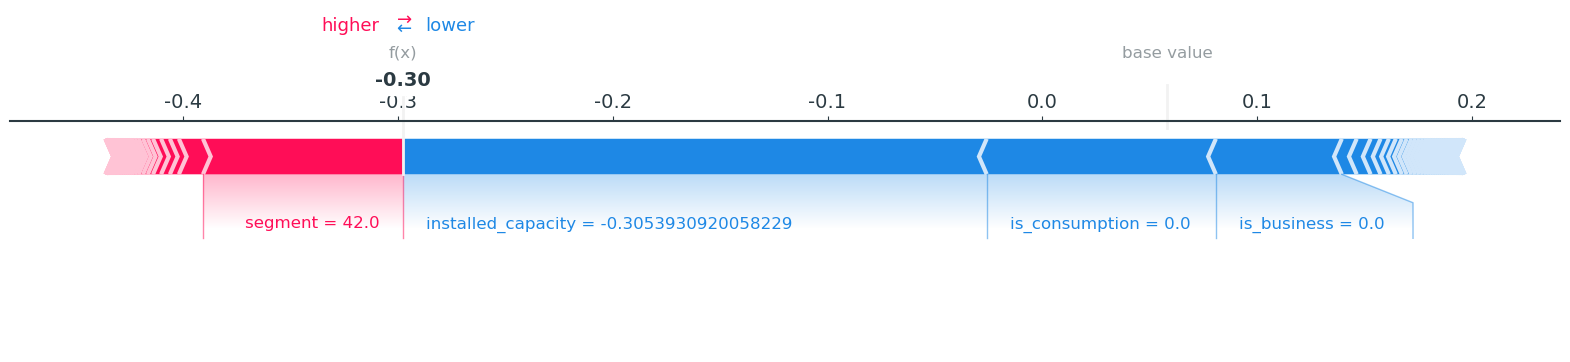

In [37]:
shap.plots.force(shap_values_lgbm[i_20], show=False, matplotlib=True)
plt.show()

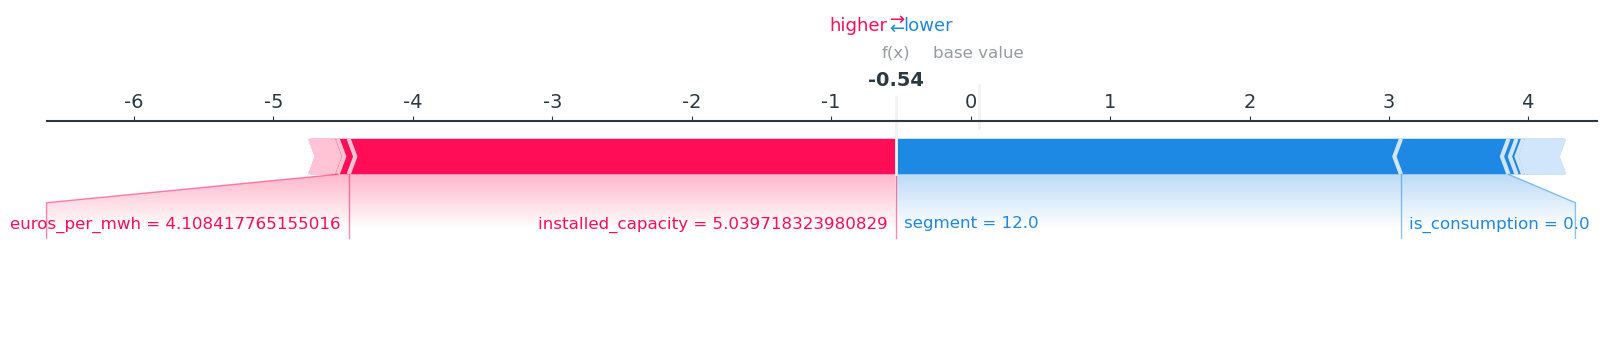

In [38]:
shap.plots.force(shap_values_lgbm[i_min], show=False, matplotlib=True)
plt.show()

In [39]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode="regression", feature_names=X_train.columns)
lime_exp_lgbm = explainer.explain_instance(X_valid.iloc[0].values, lgbm_model.predict)
file_name = f"{save_dir}/lime_explanation_lgbm.html"

lime_exp_lgbm.save_to_file(file_name)
lime_exp_lgbm.show_in_notebook()


### Build Random Forest and Improve in valid set

In [40]:
# rf= RandomForestRegressor(random_state=42, **best_params['rf_grid_search'].item())
# rf.fit(X_train, y_train)
# dump(rf, f'{save_dir}/rf_model_tuning.joblib')

rf=joblib.load(f'{save_dir}/rf_model_tuning.joblib')



In [41]:
rf_predictions = rf.predict(X_valid)
y_pred = scaler_y.inverse_transform(rf_predictions.reshape(-1, 1))
rf_mae = mean_absolute_error(target_valid, y_pred)
rf_r2 = r2_score(target_valid, y_pred)
print(f"Random Forest- Validation MAE: {rf_mae:.3f}, Validation R2: {rf_r2:.3f}")

Random Forest- Validation MAE: 2644.158, Validation R2: 0.918


### Use LIME, SHAP to explained

100%|===================| 22342/22346 [47:12<00:00]        

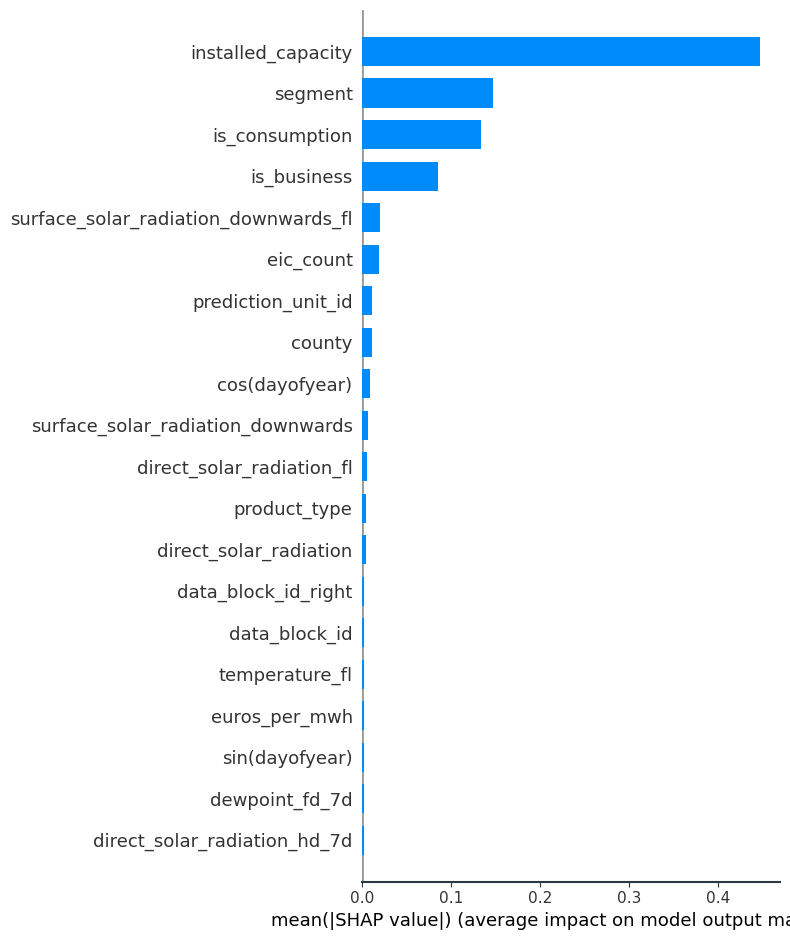

In [42]:
explainer_rf = shap.Explainer(rf, X_train)
shap_values_rf = explainer_rf(X_valid, check_additivity=False)


shap.summary_plot(shap_values_rf, X_valid, plot_type="bar", title="SHAP rf Feature Importance")



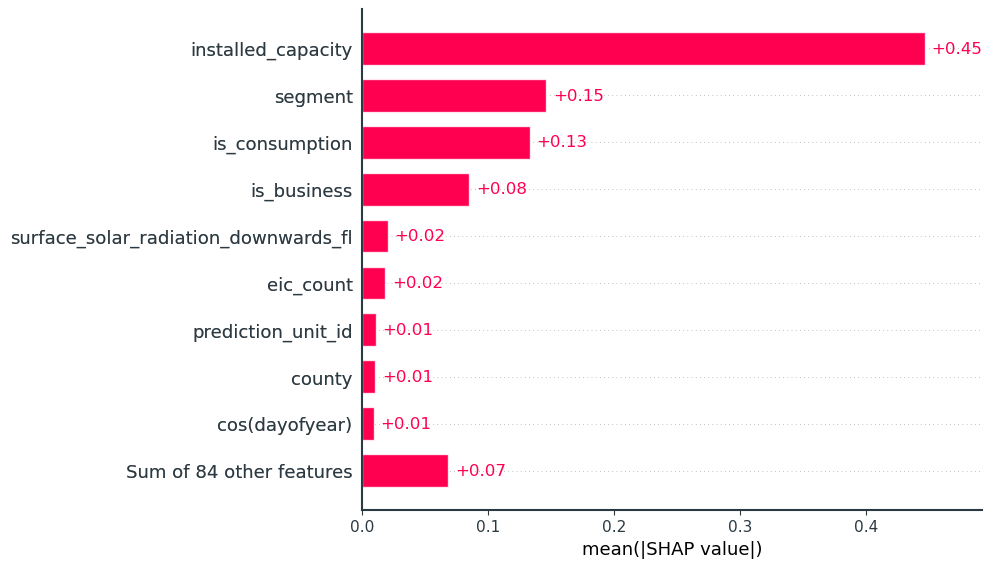

In [43]:
shap.plots.bar(shap_values_rf, show=False)
plt.show()

In [44]:
i_med = np.argsort(rf_predictions)[len(rf_predictions)//2]
i_max = np.argmax(rf_predictions)
i_80 = np.argsort(rf_predictions)[int(len(rf_predictions)*0.8)]
i_60 = np.argsort(rf_predictions)[int(len(rf_predictions)*0.6)]
i_40 = np.argsort(rf_predictions)[int(len(rf_predictions)*0.4)]
i_20 = np.argsort(rf_predictions)[int(len(rf_predictions)*0.2)]
i_min = np.argmin(rf_predictions)

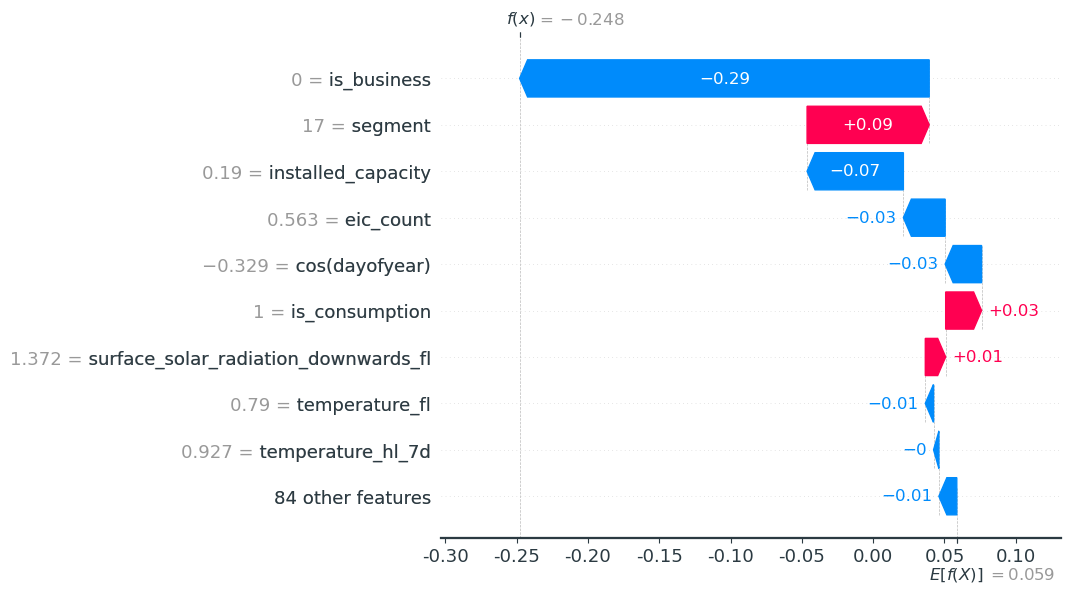

In [45]:
shap.plots.waterfall(shap_values_rf[i_med],show=True)
plt.show()

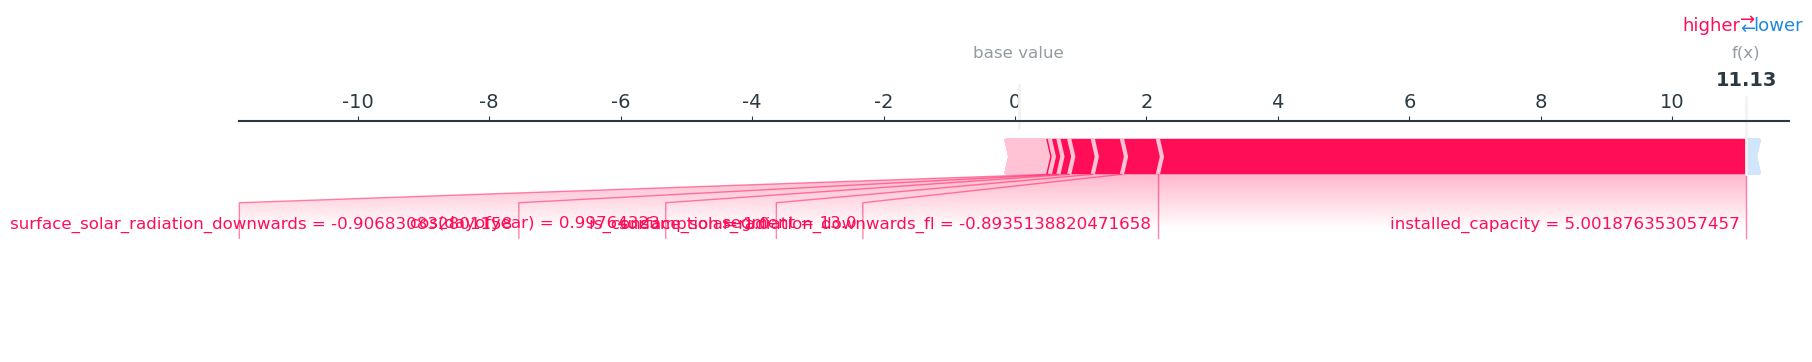

In [46]:
shap.plots.force(shap_values_rf[i_max], show=False, matplotlib=True)
plt.show()

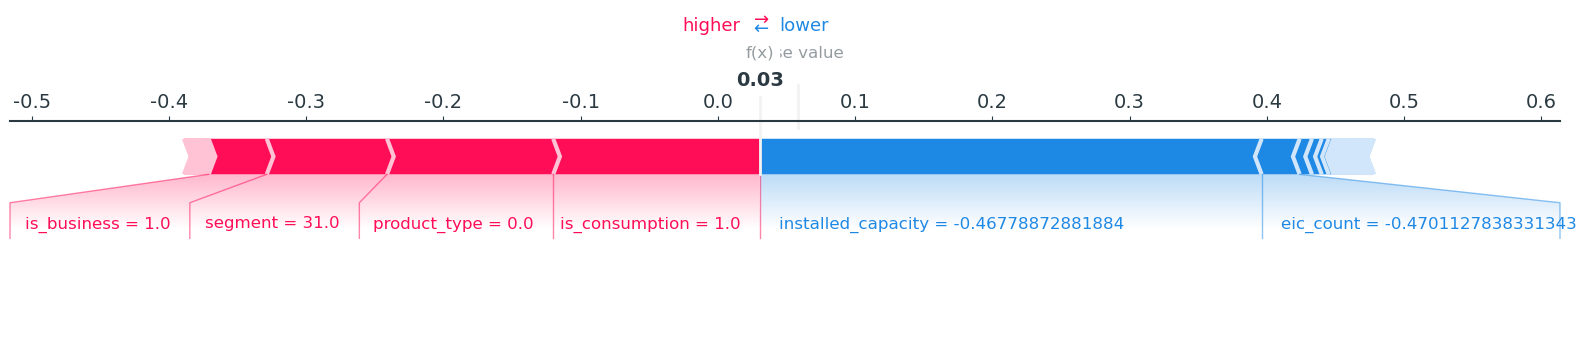

In [47]:
shap.plots.force(shap_values_rf[i_80], show=False, matplotlib=True)
plt.show()

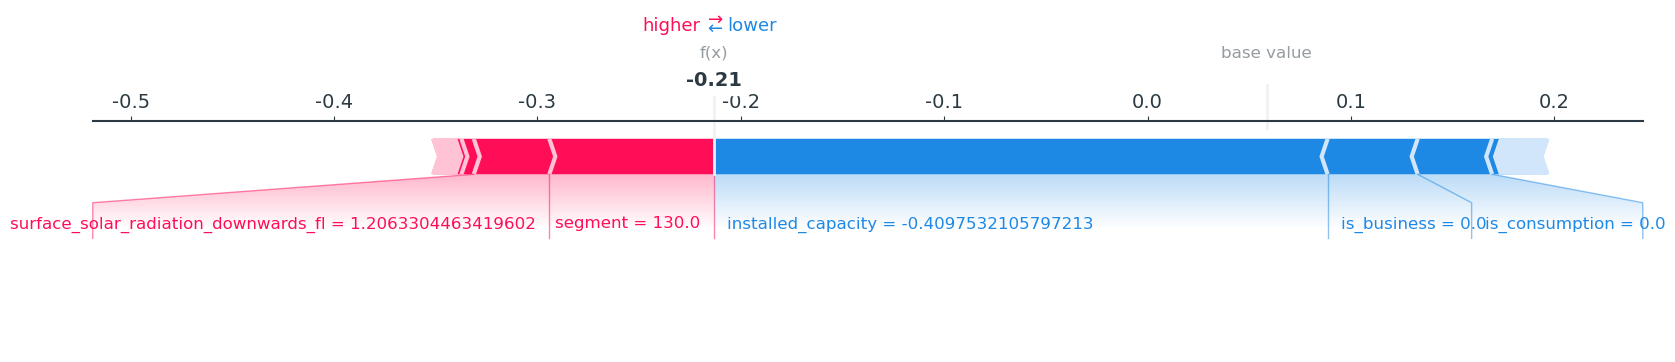

In [48]:
shap.plots.force(shap_values_rf[i_60], show=False, matplotlib=True)
plt.show()

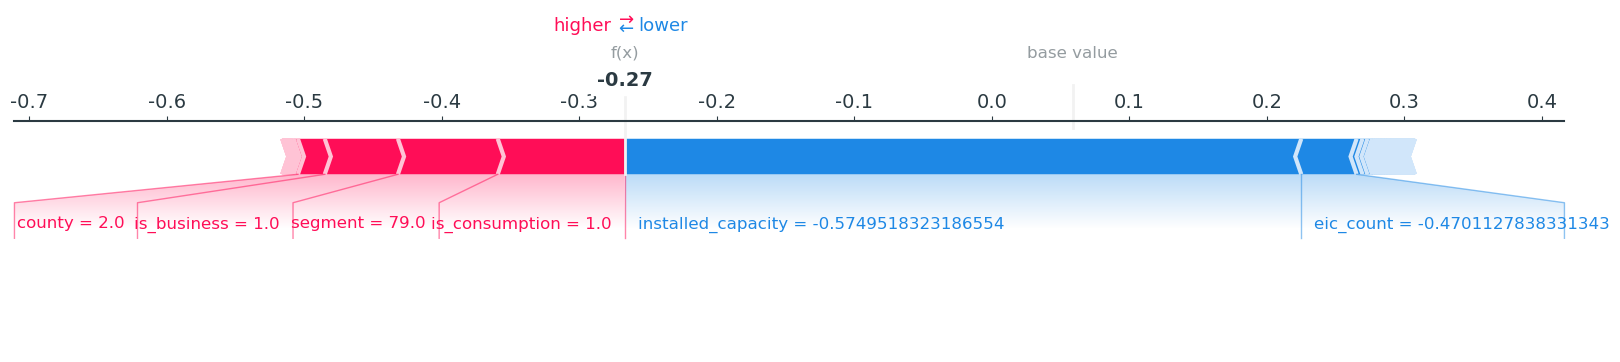

In [49]:
shap.plots.force(shap_values_rf[i_40], show=False, matplotlib=True)
plt.show()

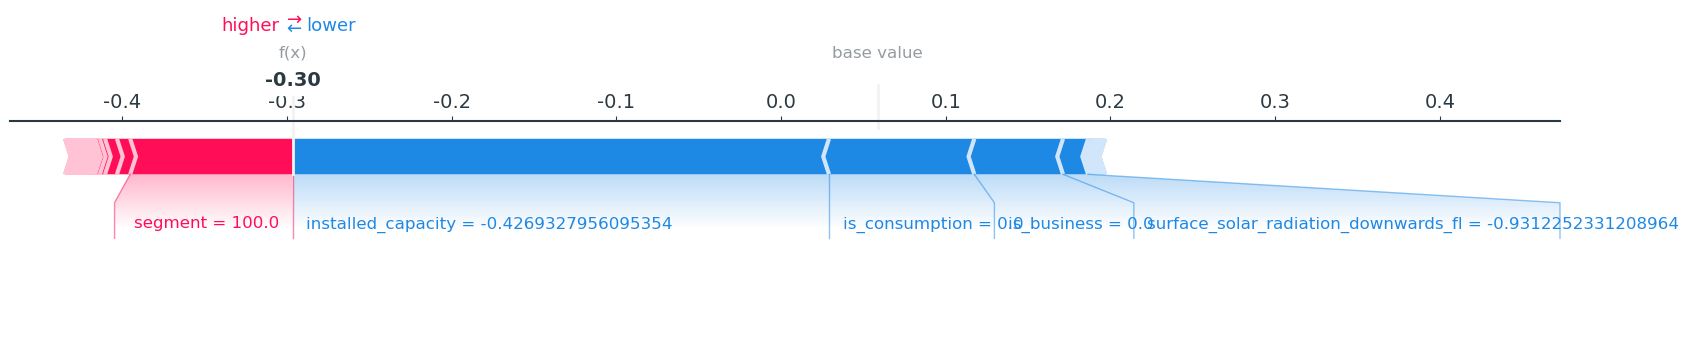

In [50]:
shap.plots.force(shap_values_rf[i_20], show=False, matplotlib=True)
plt.show()

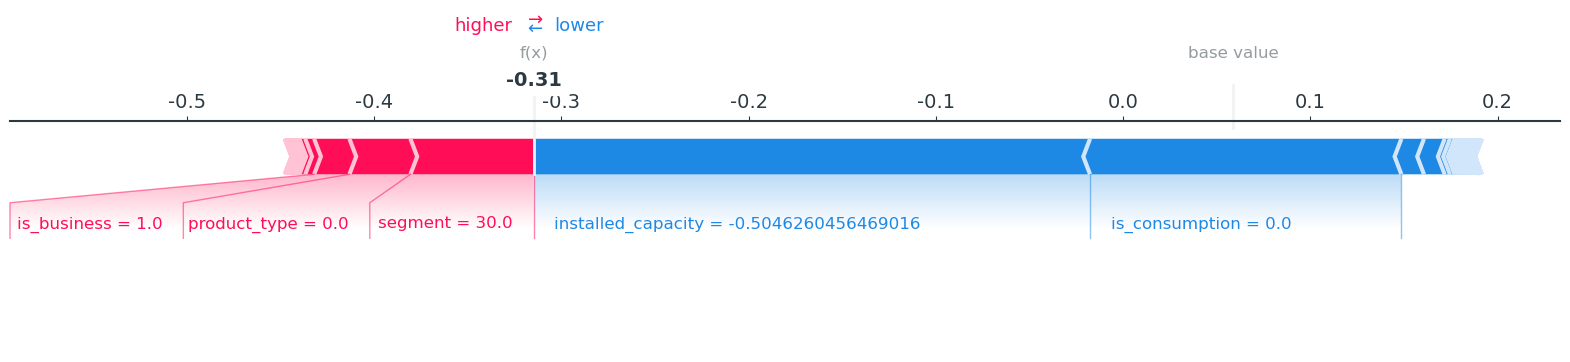

In [51]:
shap.plots.force(shap_values_rf[i_min], show=False, matplotlib=True)
plt.show()

In [52]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode="regression", feature_names=X_train.columns)
lime_exp_rf = explainer.explain_instance(X_valid.iloc[0].values, rf.predict)
file_name = f"{save_dir}/lime_explanation_rf.html"

lime_exp_rf.save_to_file(file_name)
lime_exp_rf.show_in_notebook()
